In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:]

In [ ]:
len(words)

In [ ]:
#build the vocabulary of characters and mapping to integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0;
itos = {i:s for s,i in stoi.items()}
print(itos)

In [ ]:
#build the dataset

block_size = 3 #context length: how mmany charaters do we take predict the next one
X, Y = [], []
for w in words[:]:
    # print(w)
    context = [0] * block_size # the initial case for the first character
    for ch in w+'.':
        ix = stoi[ch] # extract the current character and add in the Y as result
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

In [ ]:
C = torch.randn((27, 2))

In [ ]:
C[5]

In [ ]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C #equivlent to  C[5]

In [ ]:
C[X]

In [ ]:
X[3,1]

In [ ]:
C[X][3,1]

In [ ]:
C[13]

In [ ]:
emb = C[X]
emb.shape

In [ ]:
# construct the hidden layeer
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [ ]:
#  we want emb @ W1 + b1, but 3,2 should be flatted to 6
torch.cat(torch.unbind(emb, 1), 1).shape

In [ ]:
# a more efficient way

h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [ ]:
h.shape

In [ ]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts/counts.sum(1, keepdim=True)

In [ ]:
prob[0].sum()

In [ ]:
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

In [ ]:
F.cross_entropy(logits, Y)
#  1. more efficent because it runs in a fused kernel but also the expressions take a 
#  much simpler mathematically.(the forward pass and the backward more efficient)
#  2. more well-behaved numerically like overflow

In [ ]:
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) #number of parameters in total

In [ ]:
for p in parameters:
    p.requires_grad = True

In [113]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [152]:
lri = []
lossi = []

for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #(32, 100)
    logits = h @ W2 + b2 #(32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

print(loss.item())


2.128199815750122


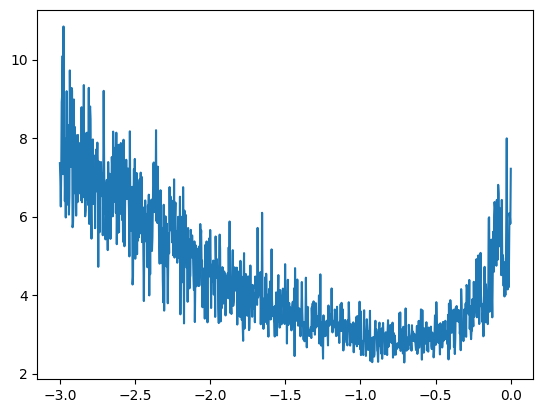

In [115]:
plt.plot(lri, lossi)

In [ ]:
torch.randint(0, X.shape[0], (32,)) ## minibatch

In [ ]:
# taining split, dev split, test split
# 80%, 10%, 10%